<font size ="4">**Importing all the libraries**</font>

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import nltk
import os
import string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from timeit import default_timer as timer

[nltk_data] Downloading package punkt to /home/u195555/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/u195555/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<font size ="4">**Downloading the dataset and extracting it to the appropriate data directory.**</font>

In [3]:
data_directory = 'data/'
if not os.path.exists(data_directory):
    !mkdir data/
    !wget https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip --directory-prefix=data/
    !unzip data/News-_dataset.zip -d data/

<font size="4">**Read the data csv file**</font>

In [4]:
fake_data = pd.read_csv('data/Fake.csv')
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
true_data = pd.read_csv('data/True.csv')
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Assigning Classes to the Dataset

In [6]:
true_data["label"] = 1
fake_data["label"] = 0

Merging Both the Dataset

In [7]:
data = pd.concat([true_data, fake_data], axis=0)

Visualization of the text data based on subject column

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

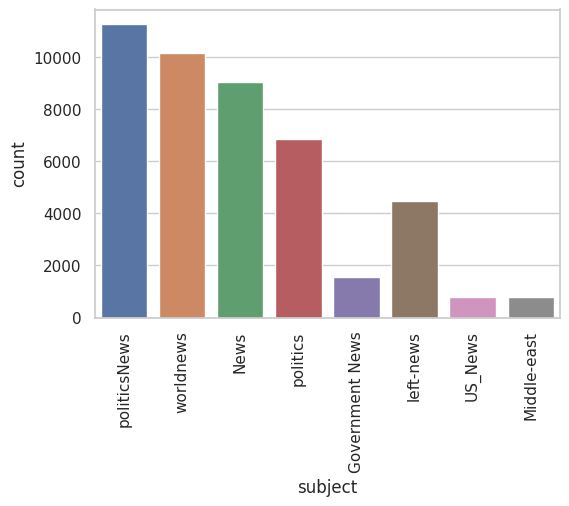

In [8]:
plt.figure(figsize = (6,4))
sns.set(style = "whitegrid",font_scale = 1.0)
chart = sns.countplot(x = "subject", data = data)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

<font size="4">**Data preprocessing**</font>

In [9]:
data['text'] = data['title'] +' '+data['text']
# Either you could data.drop["column names"] or del data["column names"]
del data['title']
del data['subject']
del data['date']

In [10]:
data.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


As the title, author column will not going to be helpful in identification of the news. So, we can drop these column.

In [11]:
data.shape

(44898, 2)

Check if there is any null value (If so, then we will drop those rows)

In [12]:
data.isnull().sum() # get the count of missing/NULL values for each column. if present remove missing values

text     0
label    0
dtype: int64

 Now we have to shuffle the dataset to prevent the model to get bias

In [13]:
#Shuffling the data by sampling it randomly, then resetting the index and dropping the previous index column
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,text,label
0,Michigan’s Republican Governor Needs Your Tax...,0
1,IRANIANS CELEBRATE NUCLEAR DEAL WITH OBAMA BY ...,0
2,"WATCH: Fox News Host DEFENDS CNN Reporter, Te...",0
3,CIA's Brennan says tearing up Iran deal would ...,1
4,Trump seeks to raise fresh ethical questions a...,1


Now Let’s explore the unique values in the each category using below code.

<Axes: xlabel='label', ylabel='count'>

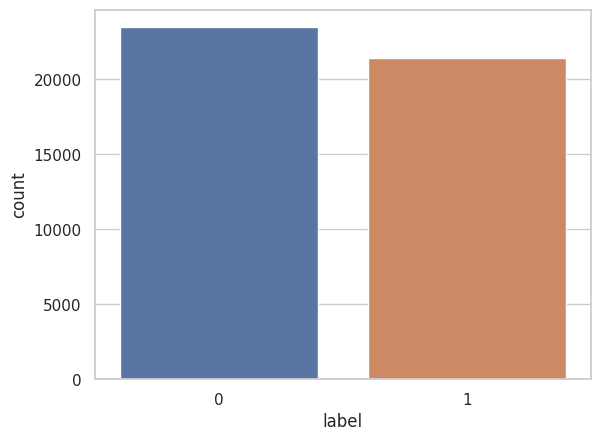

In [14]:
sns.countplot(data=data,
              x='label',
              order=data['label'].value_counts().index)

<font size="4">**Data Cleaning**</font>

In [15]:
data.dtypes

text     object
label     int64
dtype: object

In [16]:
columns = ['text','label']
for column in columns:
    data[column]=data[column].fillna("")

In [17]:
data.columns

Index(['text', 'label'], dtype='object')

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   label   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


Once we have all the required modules, we can create a function name preprocess text. This function will preprocess all the data given as input.

In [19]:
data.groupby('label')['label'].agg("count")

label
0    23481
1    21417
Name: label, dtype: int64

In [20]:
data['label'].unique()

array([0, 1])

In [21]:
data.describe()

,label
count,44898.000000
mean,0.477015
std,0.499477
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [22]:
data.head(10)

,text,label
0,Michigan’s Republican Governor Needs Your Tax...,0
1,IRANIANS CELEBRATE NUCLEAR DEAL WITH OBAMA BY ...,0
2,"WATCH: Fox News Host DEFENDS CNN Reporter, Te...",0
3,CIA's Brennan says tearing up Iran deal would ...,1
4,Trump seeks to raise fresh ethical questions a...,1
5,"U.S. Congress to let Iran deadline pass, leave...",1
6,“Peaceful” Muslims Scream: “THIS IS FOR ALLAH”...,0
7,BUSTED! CRAIGSLIST AD EXPOSES Rent-a-Mob for P...,0
8,BREAKING: US SUPREME COURT RULES King Obama Ov...,0
9,TAXPAYERS PAID SAME WOMEN WHO CRUSHED BABIES’ ...,0


In [23]:
# Data Cleaning involves identifying and correcting or removing errors from the data set to improve its quality and usability.
# Data Cleaning is important because raw data is often noisy, incomplete which can impact the accuracy.

In [24]:
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]','', text)
    text = re.sub("\\W"," ", text)
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub('<.*?>+', ' ', text)
    text = re.sub('[%s]'  % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    return text
data['text'] = data['text'].apply(wordopt)

In [25]:
x = data['text']
y = data['label']

In [26]:
data.head(10)

,text,label
0,michigan s republican governor needs your tax...,0
1,iranians celebrate nuclear deal with obama by ...,0
2,watch fox news host defends cnn reporter te...,0
3,cia s brennan says tearing up iran deal would ...,1
4,trump seeks to raise fresh ethical questions a...,1
5,u s congress to let iran deadline pass leave...,1
6,peaceful muslims scream this is for allah ...,0
7,busted craigslist ad exposes rent a mob for p...,0
8,breaking us supreme court rules king obama ov...,0
9,taxpayers paid same women who crushed babies ...,0


<font size="4">**Converting text into Vectors**</font>

In [27]:
# TFIDF Vectorizer
# TF = (Number of times term t appears in a document)/(Total number of terms in the document)
# IDF = log(n/df(t)) + 1

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

<font size="4">**Confusion Matrix**</font>

In [30]:
from sklearn import metrics
import itertools
import numpy as np
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<font size="4">**Model training, Evaluation, and Prediction**</font>

<font size="3">**LogisticRegression**</font>

In [32]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [33]:
from sklearn.linear_model import LogisticRegression
from timeit import default_timer as timer
params = {
    'C': 0.001,
    'solver': 'lbfgs',
    'penalty':'l2',
    'max_iter':1000,
    'multi_class': 'multinomial',
    'n_jobs': -1,
}
LR = LogisticRegression(**params)

start = timer()
LR.fit(xv_train, y_train)
train_patched=timer()-start
f"Intel Extension for scikit learn time: {train_patched:.2f}s"

'Intel Extension for scikit learn time: 1.90s'

In [34]:
from sklearnex import unpatch_sklearn
unpatch_sklearn()

In [35]:
from sklearn.linear_model import LogisticRegression
from timeit import default_timer as timer
start = timer()
LR = LogisticRegression(**params)
LR.fit(xv_train, y_train)
train_unpatched=timer()-start
f"Original scikit learn time: {train_unpatched:.2f}s"

'Original scikit learn time: 2.69s'

In [36]:
pred_lr = LR.predict(xv_test)

In [37]:
LR.score(xv_test, y_test)
#accuracy of Logistic Regression

0.8912249443207126

In [39]:
print(classification_report(y_test,pred_lr))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      5903
           1       0.98      0.79      0.87      5322

    accuracy                           0.89     11225
   macro avg       0.91      0.89      0.89     11225
weighted avg       0.90      0.89      0.89     11225



Confusion matrix, without normalization


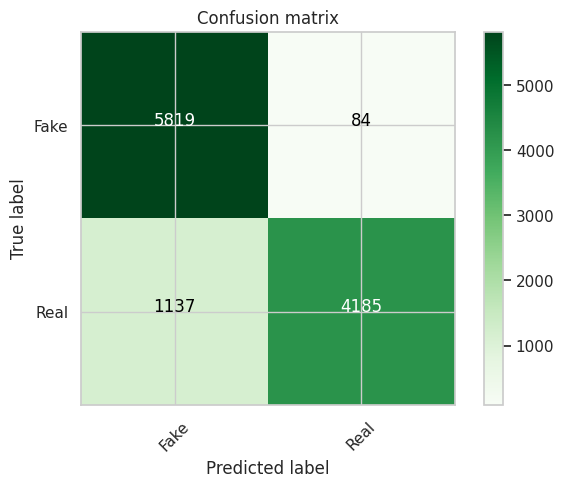

In [40]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, pred_lr)
plot_confusion_matrix(cm,classes=['Fake','Real'])

<font size="3">**DecisionTreeClassifier**</font>

In [41]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier()
DT.fit(xv_train, y_train)

DecisionTreeClassifier()

In [42]:
pred_dt = DT.predict(xv_test)

In [43]:
DT.score(xv_test,y_test)
#accuracy of DecisionTreeClassifier

0.9972383073496659

In [44]:
print(classification_report(y_test,pred_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5903
           1       1.00      1.00      1.00      5322

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



Confusion matrix, without normalization


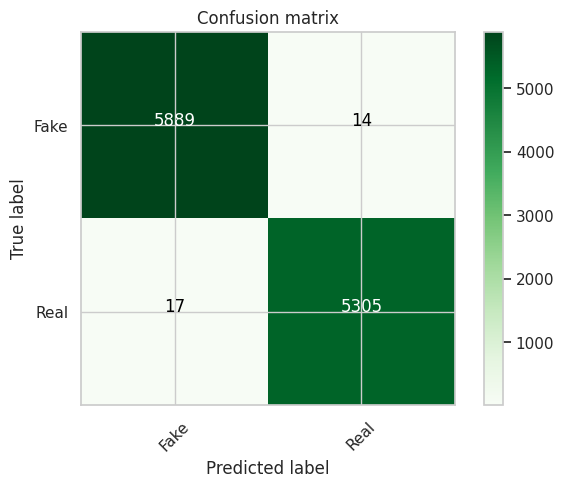

In [45]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, pred_dt)
plot_confusion_matrix(cm,classes=['Fake','Real'])

<font size="3">**GradientBoostingClassifier**</font>

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier(random_state = 0)
GB.fit(xv_train, y_train)

GradientBoostingClassifier(random_state=0)

In [49]:
pred_gb = GB.predict(xv_test)

In [50]:
GB.score(xv_test,y_test)
#accuracy of GradientBoostingClassifier

0.9961692650334075

In [51]:
print(classification_report(y_test,pred_gb))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5903
           1       0.99      1.00      1.00      5322

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



Confusion matrix, without normalization


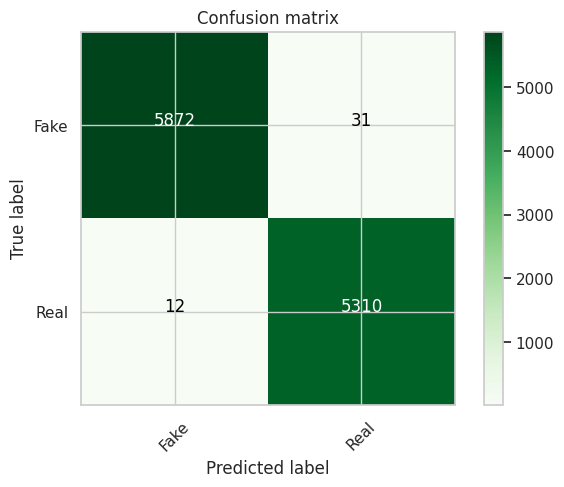

In [52]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, pred_gb)
plot_confusion_matrix(cm,classes=['Fake','Real'])

<font size="3">**RandomForestClassifier**</font>

In [99]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [100]:
from sklearn.ensemble import RandomForestClassifier
from timeit import default_timer as timer
params = {
    'n_estimators': 200,
    'random_state': 42,
    'criterion': 'entropy',
    'min_samples_leaf':1,
    'min_samples_split':2,
    'max_features': 'sqrt',
    'n_jobs': -1
}
RF=RandomForestClassifier(**params)
start = timer()
RF.fit(xv_train, y_train)
train_patched = timer() - start
f"Intel Extension for scikit learn time: {train_patched:.2f}s "

'Intel Extension for scikit learn time: 12.93s '

In [101]:
from sklearnex import unpatch_sklearn
unpatch_sklearn()

In [102]:
from sklearn.ensemble import RandomForestClassifier
from timeit import default_timer as timer
RF=RandomForestClassifier(**params)
start = timer()
RF.fit(xv_train, y_train)
train_unpatched = timer() - start
f"Original scikit learn time: {train_unpatched:.2f}s "

'Original scikit learn time: 12.97s '

In [103]:
pred_rf = RF.predict(xv_test)

In [104]:
RF.score(xv_test,y_test)
#accuracy of RandomForestClassifier

0.990467706013363

In [105]:
print(classification_report(y_test,pred_rf))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5903
           1       0.99      0.99      0.99      5322

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



Confusion matrix, without normalization


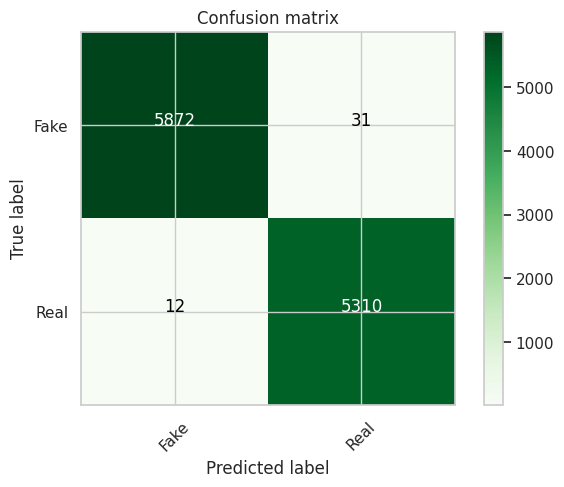

In [106]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, pred_gb)
plot_confusion_matrix(cm,classes=['Fake','Real'])

<font size="4">**Testing**</font>

In [110]:
def output(n):
    if n==0:
        return "Fake News"
    elif n==1:
        return "Not a Fake News"

    
def testing_manual(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(wordopt)
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    pred_lr = LR.predict(new_xv_test)
    pred_dt = DT.predict(new_xv_test)
    pred_gb = GB.predict(new_xv_test)
    pred_rf = RF.predict(new_xv_test)
    return print("\nLogistic Regression Prediction: {} \nDecision Tree Classifier Prediction: {} \nGradient Boost Classifier Prediction: {} \nRandom Forest Classifier Prediction: {}" .format(output(pred_lr[0]),output(pred_dt[0]),output(pred_gb[0]),output(pred_rf[0])))
#     return print("\nLR Prediction: {} \nDT Prediction: {} \nGB Prediction: {} \nRF Prediction: {}" ,pred_lr,pred_dt,pred_gb,pred_rf)

In [111]:
news = str(input())
testing_manual(news)

 WEST PALM BEACH, Fla (Reuters) - President Donald Trump said on Thursday he believes he will be fairly treated in a special counsel investigation into Russian meddling in the U.S. presidential election, but said he did not know how long the probe would last. The federal investigation has hung over Trumpâ€™s White House since he took office almost a year ago, and some Trump allies have in recent weeks accused the team of Justice Department Special Counsel Robert Mueller of being biased against the Republican president. But in an interview with the New York Times, Trump appeared to shrug off concerns about the investigation, which was prompted by U.S. intelligence agenciesâ€™ conclusion that Russia tried to help Trump defeat Democrat Hillary Clinton by hacking and releasing embarrassing emails and disseminating propaganda. â€œThereâ€™s been no collusion. But I think heâ€™s going to be fair,â€ Trump said in what the Times described as a 30-minute impromptu interview at his golf club in 


Logistic Regression Prediction: Not a Fake News 
Decision Tree Classifier Prediction: Not a Fake News 
Gradient Boost Classifier Prediction: Not a Fake News 
Random Forest Classifier Prediction: Not a Fake News
